In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Load the data
df = pd.read_csv('data/listings.csv.gz', compression='gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95144 entries, 0 to 95143
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            95144 non-null  int64  
 1   listing_url                                   95144 non-null  object 
 2   scrape_id                                     95144 non-null  int64  
 3   last_scraped                                  95144 non-null  object 
 4   source                                        95144 non-null  object 
 5   name                                          95144 non-null  object 
 6   description                                   92196 non-null  object 
 7   neighborhood_overview                         43463 non-null  object 
 8   picture_url                                   95134 non-null  object 
 9   host_id                                       95144 non-null 

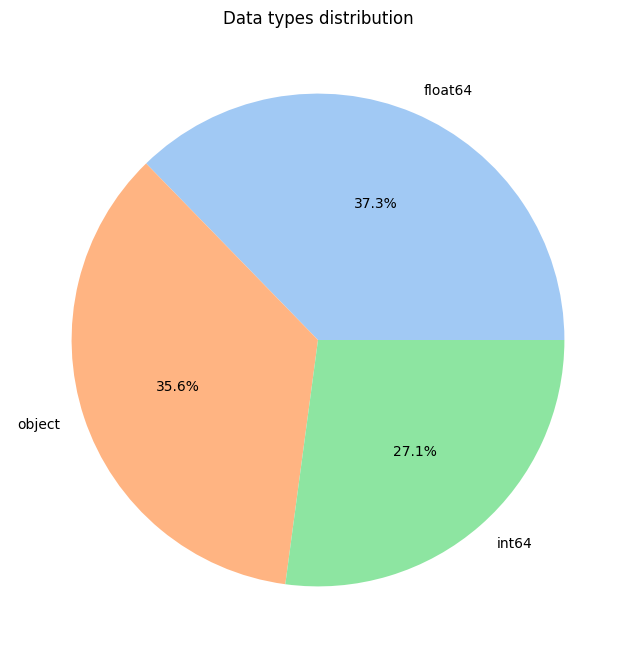

In [3]:
## Cleaning

# Remove redundant features
df = df.drop(['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'calendar_last_scraped'], axis=1)

# Remove columns with more than 50% missing values
df = df.dropna(thresh=0.5*len(df), axis=1)

# Remove columns with only one unique value
df = df.loc[:,df.apply(pd.Series.nunique) != 1]

# Convert 'price' column to floats
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Remove outliers from 'price' column
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Pie chart with dtypes
dtype_counts = df.dtypes.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(dtype_counts, labels=dtype_counts.index.astype(str), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Data types distribution')
plt.show();

#### TAKEAWAYS:
- Veel numerieke features zoals *[host_response_rate]* en *[price]* moeten van een object naar een float worden gemaakt.
- 16 Features zijn overbodig, onvolledig, of niet uniek en kunnen dus worden verwijderd.
- Groot aandeel niet-numerieke features in de data, deze kunnen door middel van feature expansion, one-hot encoding en andere methodes worden omgezet tot een numerieke waarde voor het model.

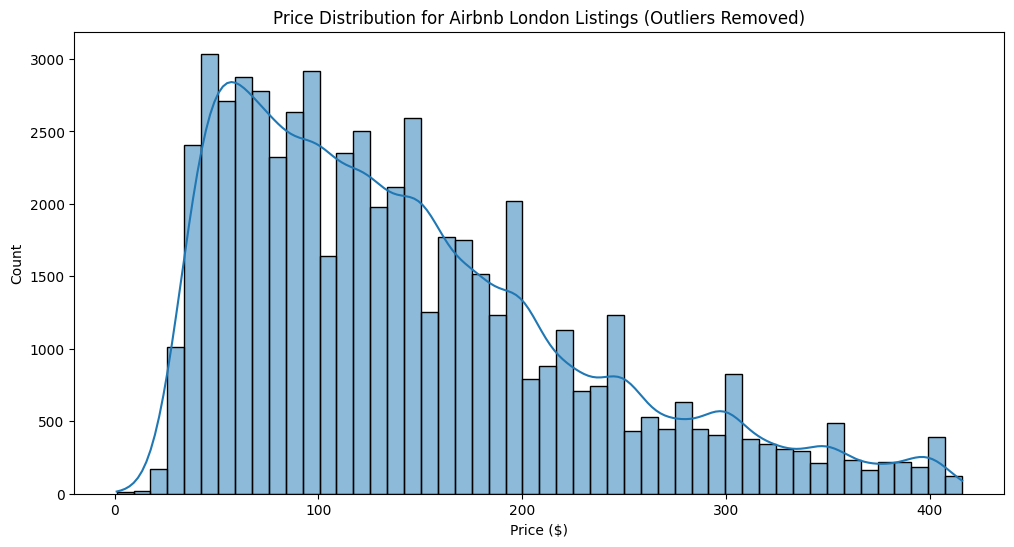

In [4]:
## Price distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution for Airbnb London Listings (Outliers Removed)")
plt.xlabel("Price ($)")
plt.show();

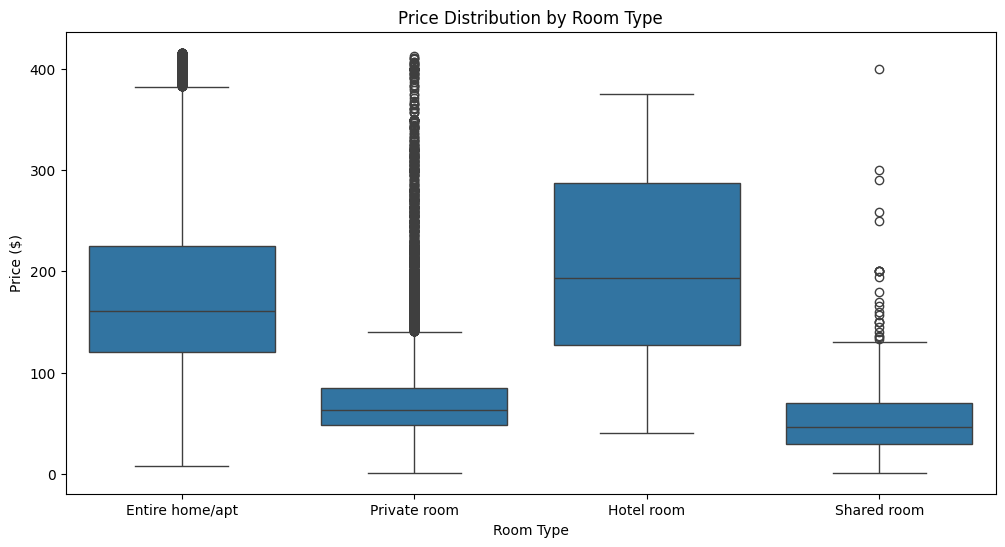

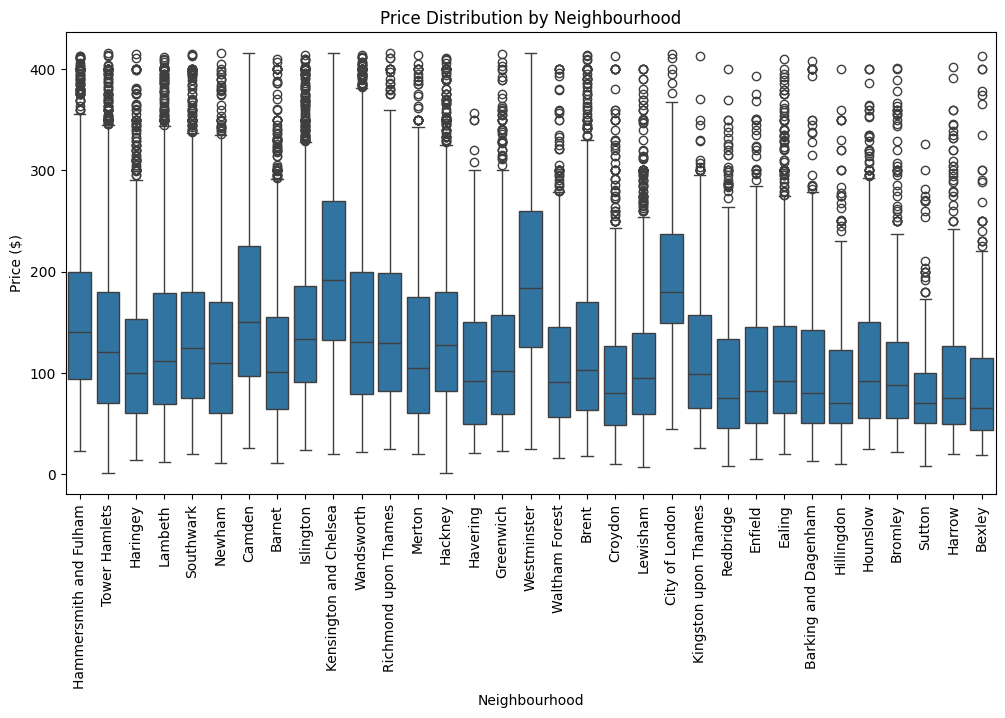

In [5]:
## Boxplots

# Price by room type
plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title("Price Distribution by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Price ($)")
plt.show();

# Price by neighbourhood
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=df)
plt.title("Price Distribution by Neighbourhood")
plt.xlabel("Neighbourhood")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)
plt.show();


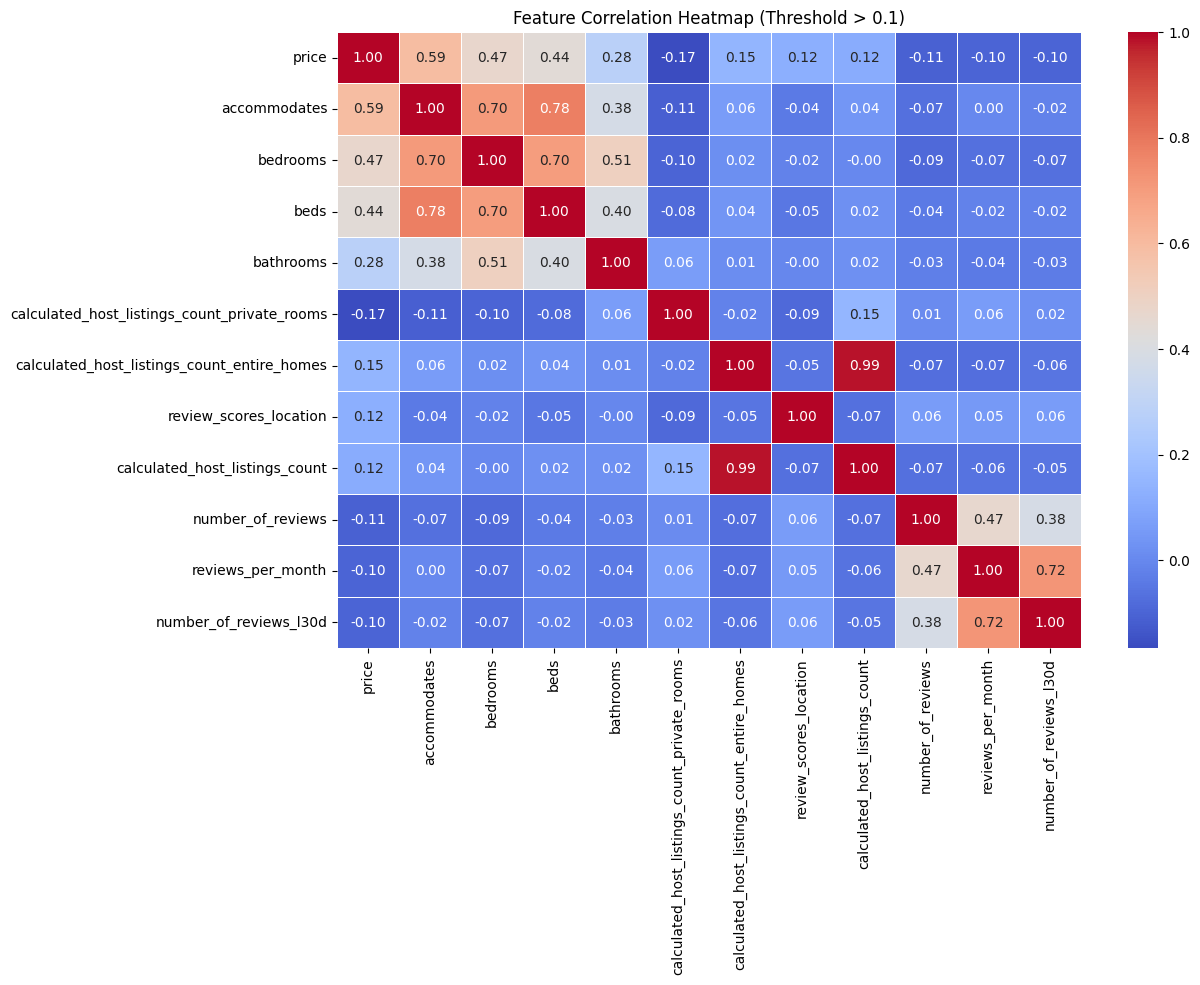

In [6]:
## Heatmap

# Set a threshold of 0.1 correlation score for feature selection
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sorted_features = corr_matrix['price'].abs().sort_values(ascending=False)
selected_features = sorted_features[sorted_features > 0.1].index

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[selected_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Threshold > 0.1)")
plt.show();

#### INFO:
- Alleen numerieke features kunnen worden meegenomen in de heatmap.
- Er zit een treshold op de correlatie values (0.1), omdat anders de heatmap onleesbaar wordt.
- Weinig numerieke features die een hoge correlatie, en dus veel invloed, hebben op de prijs (1e rij of kolom), dit bewijst dus weer dat er nog non-numerieke features moeten worden omgezet naar een numerieke waarde, zodat die mee kunnen worden genomen in de models.